# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define crucial functions to extract the qr code from the image

def get_start_and_end_points(img: np.ndarray) -> tuple:
    # define all starting points as -1 (not found yet)
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1

    # loop through the image to find the start and end points of the qr code
    # what happens here is that, initially, the value of the pixel is 255 (white)
    # so we keep looping until we find a pixel that is not white, and thus, we found the start point
    # we do the same for the end point, but we loop from the end of the image to the start
    # to find the end point. The same goes for the columns using the transpose of the image
    # to loop through the columns

    # lop through each row of pixels
    for row_index, row in enumerate(img):
        # for each pixel in that row
        for pixel in row:
            # if there is a pixel that is not white
            if pixel != 255:
                # then we found the start row
                start_row = row_index

                # break the loop
                break
        
        # if after the loop, the start row is still -1, then no non-white pixels were found, and thus we continue to the next row
        # otherwise, the next line checks if the start row was found, and if it was, it breaks the outer loop
        if start_row != -1:
            break

    # do the same for the end row, but loop through that row in reverse
    for row_index, row in enumerate(img[::-1]):
        for pixel in row:
            if pixel != 255:
                end_row = img.shape[0] - row_index
                break
        if end_row != -1:
            break

    # do the same for the columns, but using the transpose of the image
    for col_index, col in enumerate(cv2.transpose(img)):
        for pixel in col:
            if pixel != 255:
                start_col = col_index
                break
        if start_col != -1:
            break

    # do the same for the end column, but using the transpose of the image and looping in reverse
    for col_index, col in enumerate(cv2.transpose(img)[::-1]):
        for pixel in col:
            if pixel != 255:
                end_col = img.shape[1] - col_index
                break
        if end_col != -1:
            break

    # return the start and end points
    return start_row, start_col, end_row, end_col


def apply_kernel(img, kernel):
    # Apply filter
    filtered = cv2.filter2D(img, -1, kernel)
    
    # Convert the result back to uint8
    back_to_int = np.uint8(np.absolute(filtered))
    
    # Add the Laplacian result to the original image to sharpen it
    return cv2.add(img, back_to_int)


def get_grid_cell_size_and_num(qr_no_quiet_zone: np.ndarray) -> tuple:
    # get the size of the first non-white pixel in the qr code
    size = 0
    for pixel in qr_no_quiet_zone[0]:
        if (pixel != 0): break
        size += 1
    
    # The size of the grid cell is the size of the qr code divided by 7, which is the width of the top-left border of the alignment pattern
    grid_cell_size = round(size/7)

    # The number of grid cells is the size of the qr code divided by the size of the grid cell
    grid_cells_num = round(qr_no_quiet_zone.shape[0]/grid_cell_size)

    # return the size of the grid cell and the number of grid cells
    return grid_cell_size, grid_cells_num

def get_numeric_qr_cells(img: np.ndarray) -> np.ndarray:
    # get the start and end idxs of the qr code
    start_row, start_col, end_row, end_col = get_start_and_end_points(img)

    # get the qr code without the quiet zone
    qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]

    # get the size of a grid cell and the number of grid cells
    grid_cell_size, grid_cells_num = get_grid_cell_size_and_num(qr_no_quiet_zone)

    # reshape the qr code to a 2D array of grid cells
    qr_cells = qr_no_quiet_zone.reshape((
        grid_cells_num,
        grid_cell_size,
        grid_cells_num,
        grid_cell_size,
    )).swapaxes(1, 2)

    # form an empty array to store the numeric values of the qr cells
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)

    # loop through the qr cells and get the median value of each cell
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)
    
    # return the numeric qr cells
    return qr_cells_numeric

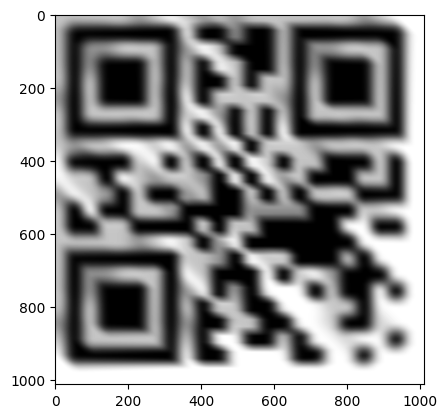

In [3]:
# read image
img = cv2.imread('test_data/9_blurred.png', cv2.IMREAD_GRAYSCALE)

# pass it to function
# qr_cells_numeric = get_numeric_qr_cells(img)

# init laplacian kernel
laplacian_kernel = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
])

blur_kernel = 1 / 9 * np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

linear_kernel = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

def remove_motion_blur(img, blur_kernel_size):
    
    # Create a motion blur kernel
    motion_blur_kernel = np.zeros((blur_kernel_size, blur_kernel_size))
    motion_blur_kernel[int((blur_kernel_size-1)/2), :] = np.ones(blur_kernel_size)
    motion_blur_kernel /= blur_kernel_size
    
    # Perform Wiener deconvolution
    restored_image = cv2.filter2D(img, -1, cv2.flip(motion_blur_kernel, -1))
    
    return restored_image

# laplacian_filtered = cv2.Laplacian(img, -1, ksize=5)

# # apply kernel
# final = img + laplacian_filtered

img = remove_motion_blur(img, 31)


# plot
plt.imshow(img, cmap='gray')

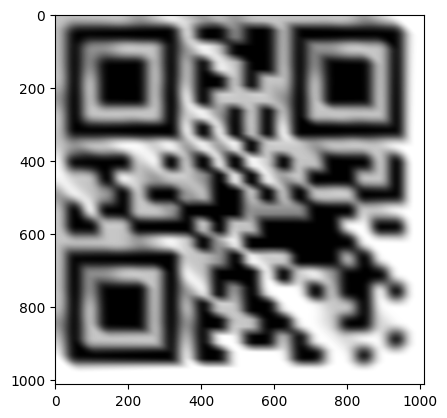

In [81]:
def determine_motion_blur_direction(img):
    
    # Compute the gradient using Sobel operators
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculate the gradient magnitude and direction
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_direction = np.arctan2(sobely, sobelx)
    
    # Calculate the average gradient direction
    avg_gradient_direction = np.degrees(np.mean(gradient_direction))
    
    return avg_gradient_direction

def remove_motion_blur(img, blur_kernel_size, blur_angle):
    # Create a motion blur kernel
    motion_blur_kernel = cv2.getRotationMatrix2D((blur_kernel_size/2, blur_kernel_size/2), blur_angle, 1)
    motion_blur_kernel = cv2.warpAffine(np.eye(blur_kernel_size), motion_blur_kernel, (blur_kernel_size, blur_kernel_size))
    motion_blur_kernel /= blur_kernel_size
    
    # Perform deconvolution using Wiener deconvolution
    restored_image = cv2.filter2D(img, -1, cv2.flip(motion_blur_kernel, -1))
    
    return restored_image

blur_kernel_size = 7
motion_blur_angle = determine_motion_blur_direction(img)
deblurred = remove_motion_blur(img, blur_kernel_size, motion_blur_angle)

plt.imshow(deblurred, cmap='gray')

In [5]:
def fix_qr_image(img):
    """
    Takes a grayscale QR image and returns a valid QR-readable image
    with enhanced contrast and noise reduction.
    
    Args:
    image (np.array): A grayscale image of a QR code.
    
    Returns:
    np.array: A processed QR image with only white/black pixels.
    """
    # Apply adaptive thresholding to binarize the image with white/black squares
    binary_image = cv2.threshold(src=img,
                                thresh=100,
                                maxval=255,
                                type=cv2.THRESH_BINARY)[1]
    
    # Use a kernel for morphological operations that suits the size of the QR code
    kernel_size = int(min(img.shape) * 0.01)  # 1% of the smallest dimension
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply morphological closing to clean small holes and dots in the QR code
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)


    # Apply morphological opening to remove noise around the QR code
    opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)
    
    return opened_image

# Process the image
qr_readable_image = fix_qr_image(img)

# plt.imshow(qr_readable_image, cmap='gray')

In [6]:
qr_readable_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

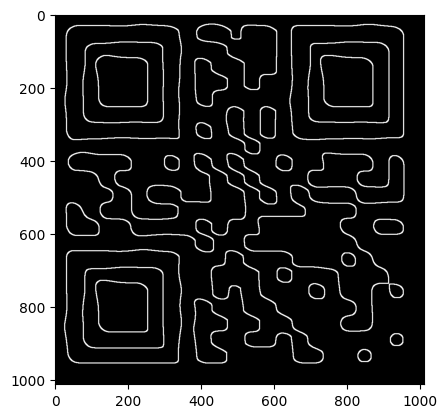

In [19]:
# Apply Canny edge detection
edges = cv2.Canny(qr_readable_image, 120, 150)

# Perform dilation to thicken the edges
kernel = np.ones((3,3), np.uint8)
dilated_edges = cv2.dilate(edges, kernel, iterations=1)

# Apply threshold to make the edges sharp
_, sharp_edges = cv2.threshold(dilated_edges, 200, 255, cv2.THRESH_BINARY)

# Display the sharp edges
plt.imshow(sharp_edges, cmap='gray')

[ WARN:0@4848.428] global loadsave.cpp:248 findDecoder imread_('image.jpg'): can't open/read file: check file path/integrity


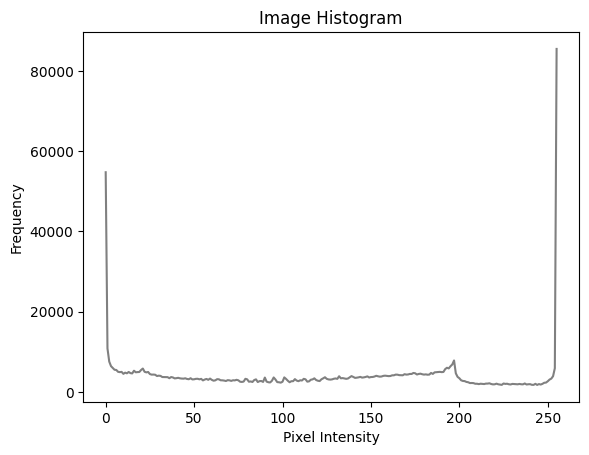

In [98]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

# Calculate histogram
hist = cv2.calcHist([img], [0], None, [256], [0, 256])

# Plot histogram
plt.plot(hist, color='gray')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Image Histogram')
plt.show()

In [42]:
img.shape

(1012, 1012)

In [26]:
print(qr_cells_numeric.shape, qr_cells_numeric2.shape)

(21, 21) (33, 33)


# About QR codes
###### *Main reference:* &nbsp;&nbsp; https://en.wikipedia.org/wiki/QR_code
###### *Useful video:* &nbsp;&nbsp; https://youtu.be/KA8hDldvfv0

<br/>
<br/>

First, let's see what a QR code is made up of...

![Structure of a QR code (version 7), highlighting functional elements.](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/QR_Code_Structure_Example_3.svg/1280px-QR_Code_Structure_Example_3.svg.png)
> *Structure of a QR code (version 7), highlighting functional elements.*

<br/>
<br/>

## 1. Version Information
The top-right finder pattern cell has a short field of data that is contained there. This lets us know which QR code version is being scanned.

The two blue version information boxes in the example image above are mirror images of each other.

Version and format information is doubly redundant in QR codes.
## 2. Format information

The red format information next to the bottom locator box matches the format information below the top left locator box, and the red format information below the top right locator box matches the format information to the right of the top left locator box.

Version and format information is doubly redundant in QR codes.

![Meaning of format information.](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/QR_Format_Information.svg/1024px-QR_Format_Information.svg.png)
> *Meaning of format information.*

<br/>
<br/>

## 3. Data (incl. error correction)
The message that the QR code includes, with error correction redundancy.

![Message placement within a Ver 1 QR symbol (21×21).](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/QR_Character_Placement.svg/640px-QR_Character_Placement.svg.png)
> *Message placement within a Ver 1 QR symbol (21×21).*

<br/>
<br/>

## 4. Other patterns
### 4.1. Position (locator/finder) pattern
The three large squares ("locator boxes") at the corners of the QR code give you enough information about the location and overall orientation of the QR code. They are 7x7 black and white cells, surrounded by white padding wrt their position.

If you can identify those three squares in an image, then you have identified that a QR code exists within their contour.
### 4.2 Alignment pattern
This pattern of squares ensures that you get the orientation of the QR code right, in case it is tilted or skewed.
### 4.3 Timing pattern
This L-shaped pattern connects the three squares. A damaged QR code can still be read because of the timing pattern, which enables the reader to distinguish between specific squares within the entire code.

It is composed of alternating black and white pixels, starting with a black pixel right after the locator box white border.
## 5. Quiet Zone
This is the perimeter of a QR code. It is blank (white).

A QR reader needs this border to distinguish what is and isn't contained in the QR code (due to interference from outside elements).

# Example

## Import and binarize
Must make sure that the image is full of 0s or 255s for further processing

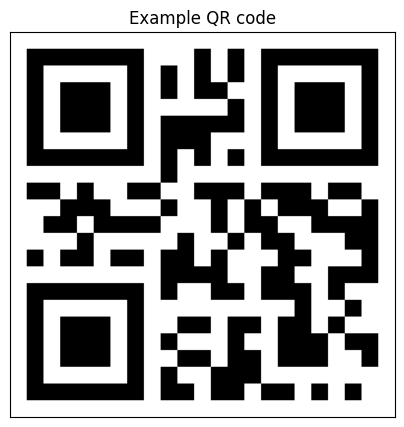

In [8]:
img = cv2.imread("test_data/01-Getting-started.png", cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.title('Example QR code')
plt.imshow(img, cmap='gray');

## Use quiet zone to detect code area
Simply go through white rows and columns until you find the first black pixel from the left, from the right, from the top, and from the bottom.

In [10]:
start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break

print(start_row, end_row, start_col, end_col)

44 968 44 968


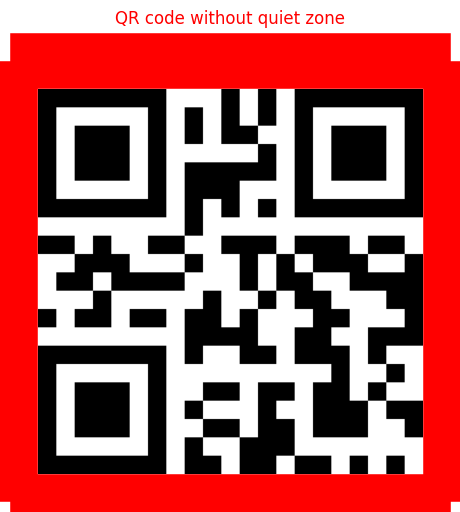

In [11]:
qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
fig.get_axes()[0].spines[:].set_color('red');
fig.get_axes()[0].spines[:].set_linewidth(40);
fig.get_axes()[0].spines[:].set_position(("outward", 20))
plt.title('QR code without quiet zone', y = 1.15, color='red');
plt.imshow(qr_no_quiet_zone, cmap='gray');

## Use locator boxes to determine grid size
Since we know that the topleft pixel should be the border of the locator box, and that its size should be 7×7, we can determine the grid cell size by dividing its size in pixels by 7. How to get its size? It is a constant black row of pixels followed by one white cell. A simple for loop can get it done.

In [12]:
size = 0
for pixel in qr_no_quiet_zone[0]:
    if (pixel != 0): break
    size += 1

print(size)

308


In [13]:
# Therefore the grid cell size is..
grid_cell_size = round(size/7)
print(grid_cell_size)

44


In [14]:
# And it each row/column is expected to have the following no. of qr_cells
grid_cells_num = round(qr_no_quiet_zone.shape[0]/grid_cell_size)
print(grid_cells_num)

21


In [15]:
# So now it is time to split the following shape...
print(qr_no_quiet_zone.shape)

(924, 924)


In [16]:
# ...into grid cells
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)
print(qr_cells.shape)

(21, 21, 44, 44)


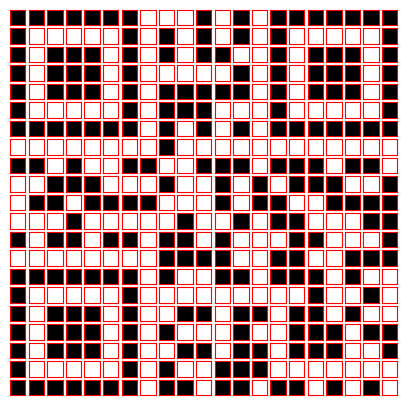

In [17]:
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        col.spines[:].set_color('red')

## Convert grid tiles to numeric values

In [ ]:
def get_numeric_qr_cells(img):
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1

    for row_index, row in enumerate(img):
        for pixel in row:
            if pixel != 255:
                start_row = row_index
                break
        if start_row != -1:
            break

    for row_index, row in enumerate(img[::-1]):
        for pixel in row:
            if pixel != 255:
                end_row = img.shape[0] - row_index
                break
        if end_row != -1:
            break

    for col_index, col in enumerate(cv2.transpose(img)):
        for pixel in col:
            if pixel != 255:
                start_col = col_index
                break
        if start_col != -1:
            break

    for col_index, col in enumerate(cv2.transpose(img)[::-1]):
        for pixel in col:
            if pixel != 255:
                end_col = img.shape[1] - col_index
                break
        if end_col != -1:
            break

    print(start_row, end_row, start_col, end_col)
    qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
    qr_cells = qr_no_quiet_zone.reshape((
        grid_cells_num,
        grid_cell_size,
        grid_cells_num,
        grid_cell_size,
    )).swapaxes(1, 2)
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)

print(qr_cells_numeric)

[[0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0]
 [0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0]
 [0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0]
 [1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0]
 [0 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0]
 [1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1]
 [0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1]
 [0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1]
 [0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1]
 [0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1]
 [0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1]]


## Information extraction

![Meaning of format information.](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/QR_Format_Information.svg/640px-QR_Format_Information.svg.png)
> *Meaning of format information.*

### Error correction level

In [ ]:
# We want row #8
qr_cells_numeric[8]

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0],
      dtype=uint8)

In [ ]:
# The first two bits determine the error correction level
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.
ecl = [int(not(c)) for c in qr_cells_numeric[8, 0:2]]
# Why "not"? Because the standard uses '1's for black and '0's for white
#
# "A dark module is a binary one and a light module is a binary zero."
#  - ISO/IEC 18004:2000(E)
#
# In image processing, we use them the other way.. Hence the inversion
print(ecl)

[1, 1]


### Mask pattern

In [ ]:
# Dictionary of all masks and their equivalent formulae
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

# Same row as above, the three cells after the ecl cells (converted to a string)
mask = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
mask_str = ''.join([str(c) for c in mask])
print(mask_str)

110


### Format error correction

In [ ]:
# Same row as above, but we want cells #5 and #7 (#6 is always set to 0),
#  followed by column #8 from cell #0 in it to cell #7 (and skipping #6)
fec = []
fec.append(qr_cells_numeric[8, 5])
fec.append(qr_cells_numeric[8, 7])
fec.extend(qr_cells_numeric[0:6, 8])
fec.extend(qr_cells_numeric[7:9, 8])
fec = [int(not(c)) for c in fec]
print(fec)

[0, 0, 1, 0, 1, 1, 1, 0, 0, 1]


In [ ]:
# So in total we have the following 15 bits of format info from our QR code
print(ecl, mask, fec)

[1, 1] [1, 1, 0] [0, 0, 1, 0, 1, 1, 1, 0, 0, 1]


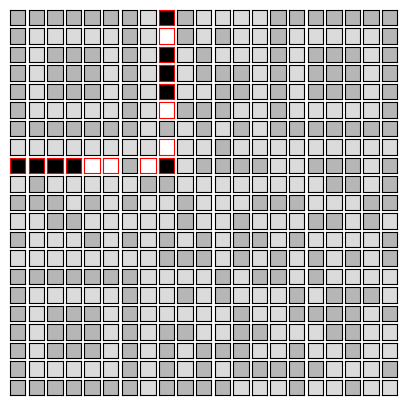

In [ ]:
# Let's cross-check with our example
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):

        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        if (i == 8 and j <= 8) or (i <= 8 and j == 8):
            if (i != 6) and (j != 6):
                col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
                col.spines[:].set_color('red')
                continue
        col.imshow(qr_cells[i][j], cmap="gray", vmin=-1275, vmax=510)

In [ ]:
# However..... You need to XOR that with the "format mask": 101010000010010
ecl[0] ^= 1
mask[0] ^= 1
mask[2] ^= 1
fec[5] ^= 1
fec[8] ^= 1

# And now we print...
print(ecl, mask, fec)

[0, 1] [0, 1, 1] [0, 0, 1, 0, 1, 0, 1, 0, 1, 1]


## Data extraction

![Message placement within a Ver 1 QR symbol (21×21).](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/QR_Character_Placement.svg/640px-QR_Character_Placement.svg.png)
> *Message placement within a Ver 1 QR symbol (21×21). Example from wikipedia, encoded QR message is www.wikipedia.org*

In [ ]:
# Before we proceed, let's write a function for masking to make our lives easier
UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"

def apply_mask(data_start_i, data_start_j, direction):
    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''
    result = []
    row_offsets = []
    col_offsets = []
    if (direction in [UP, UP_ENC]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == DOWN):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]

    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
        result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))

    return result[:4] if direction == UP_ENC else result

### Data encoding

In [ ]:
enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
print(enc)

[0, 1, 0, 0]


### Data length

In [ ]:
len = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
print(len)

[0, 0, 0, 1, 0, 0, 0, 1]


### Data extraction

In [ ]:
data_starting_indices = [
    [grid_cells_num-7, grid_cells_num-1, UP],
    [grid_cells_num-11, grid_cells_num-1, CCW],
    [grid_cells_num-10, grid_cells_num-3, DOWN],
    [grid_cells_num-6, grid_cells_num-3, DOWN],
    [grid_cells_num-2, grid_cells_num-3, CW],
    [grid_cells_num-3, grid_cells_num-5, UP],
    [grid_cells_num-7, grid_cells_num-5, UP],
    [grid_cells_num-11, grid_cells_num-5, CCW],
    [grid_cells_num-10, grid_cells_num-7, DOWN],
    [grid_cells_num-6, grid_cells_num-7, DOWN],
    [grid_cells_num-2, grid_cells_num-7, CW],
    [grid_cells_num-3, grid_cells_num-9, UP],
    [grid_cells_num-7, grid_cells_num-9, UP],
    [grid_cells_num-11, grid_cells_num-9, UP],
    [grid_cells_num-16, grid_cells_num-9, UP],
    [grid_cells_num-20, grid_cells_num-9, CCW],
    [grid_cells_num-19, grid_cells_num-11, DOWN],
    [grid_cells_num-14, grid_cells_num-11, DOWN],
    [grid_cells_num-10, grid_cells_num-11, DOWN],
    [grid_cells_num-6, grid_cells_num-11, DOWN],
    # Hmm..? I actually don't know how to proceed now lol
]

ans = ''
for a, b, d in data_starting_indices:
    bits = apply_mask(a, b, d)
    bit_string = ''.join([str(bit) for bit in bits])
    if bit_string[:4] == "0000":
        print(f'{bit_string[:4]} = 0 (NULL TERMINATOR)')
        break
    ans += chr(int(bit_string, 2)) # converts to binary to int, then to ASCII
    print(f'{bit_string} = {ans[-1]}')

print(f'\nDecoded string: {ans}')

01001000 = H
01100101 = e
01101100 = l
01101100 = l
01101111 = o
00101100 = ,
00100000 =  
01010001 = Q
01010010 = R
00100000 =  
01010111 = W
01101111 = o
01110010 = r
01101100 = l
01100100 = d
00100001 = !
00110001 = 1
0000 = 0 (NULL TERMINATOR)

Decoded string: Hello, QR World!1


# Another (more summarized) example

00110001 = 1
01110001 = q
01100001 = a
01111010 = z
00100001 = !
01010001 = Q
01000001 = A
01011010 = Z
01000000 = @
01010111 = W
01010011 = S
01011000 = X
00101111 = /
01011100 = \
00100111 = '
01011011 = [
01011101 = ]
0000 = 0 (NULL TERMINATOR)

Decoded string: 1qaz!QAZ@WSX/\'[]


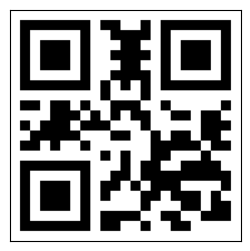

In [ ]:
img = cv2.imread("QR_2_Symbols.png", cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize=(3, 3));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img, cmap='gray')

start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break

qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]

size = 0
for pixel in qr_no_quiet_zone[0]:
    if (pixel != 0): break
    size += 1

grid_cell_size = round(size/7)
grid_cells_num = round(qr_no_quiet_zone.shape[0]/grid_cell_size)
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)

qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(qr_cells):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)

mask = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
mask_str = ''.join([str(c) for c in mask])

mask[0] ^= 1
mask[2] ^= 1

ans = ''
for a, b, d in data_starting_indices:
    bits = apply_mask(a, b, d)
    bit_string = ''.join([str(bit) for bit in bits])
    if bit_string[:4] == "0000":
        print(f'{bit_string[:4]} = 0 (NULL TERMINATOR)')
        break
    ans += chr(int(bit_string, 2)) # converts to binary to int, then to ASCII
    print(f'{bit_string} = {ans[-1]}')

print(f'\nDecoded string: {ans}')

<hr/>

Now your job is to include redundant data, look into the error correcting mechanism(s), and perhaps look into newer QR code versions (although that will probably be too difficult, so keep that as a challenge if you find everything else easy). *Good luck :)*

**Here's for example the structure of a version 3 QR code:**
![Version 3 QR Code illustrating interleaved Reed-Solomon blocks](https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/QR_Ver3_Codeword_Ordering.svg/1280px-QR_Ver3_Codeword_Ordering.svg.png)
> Version 3 QR Code illustrating interleaved Reed-Solomon blocks